In [ ]:
!pip install ipywidgets
!pip3 install seaborn
!pip3 install openTSNE
!pip3 install timm
!pip3 install wandb
!pip3 install easydict

     |████████████████████████████████| 2.4 MB 5.8 MB/s 
     |████████████████████████████████| 431 kB 12.2 MB/s 
     |████████████████████████████████| 1.7 MB 12.3 MB/s 
     |████████████████████████████████| 143 kB 47.5 MB/s 
     |████████████████████████████████| 97 kB 7.1 MB/s 
     |████████████████████████████████| 180 kB 47.2 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=3d3f0999f2dc58fdd8819f83d949d773184a5c7211f05201a34354137f6baf51
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=cdc228c629e5d130dfafe2ba97e30f45879c62b2a19011a8e07cfb822d1ccce6
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
import os
import numpy as np
import torch
from torchvision.utils import make_grid
from utils import *
from easydict import EasyDict
from openTSNE import TSNE

In [ ]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
set_random_seed(se=10)



args = EasyDict({'tuning_type':'last_layer', 'tuning_dataset':'cifar10', 'batch_size':16, 'setting':'Poison', 'budgets':1,
                 'max_iter': 1000, 'beta_0':0.1, 'opacity':0, 'lr':0.001, 'scheduler':False, 'epochs':100, 'early_stop':False,
                    'wandb':False, 'train_samples': 2500, 'model':'mnasnet_100'})

In [ ]:
num_classes = 10 if args.tuning_dataset == 'cifar10' else 2

transform, model = gen_model(args=args,
                            architecture=args.model,
                            dataset='imagenet',
                            pretrained=True,
                            num_classes=num_classes)
model = model.to(device)


In [ ]:
train_loader, val_loader, test_loader, train_set, class_to_idx = gen_data(args=args, dataset=args.tuning_dataset, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
idx_to_class = {value:key for key, value in class_to_idx.items()}



In [ ]:
if args.setting == "Poison":
    # base and target instances
    if args.tuning_dataset == "cat-dog":
        base_instance_name, target_instance_name = 'cat', 'dog'
    else:
        selected_class = np.random.choice(list(idx_to_class.values()), 2,replace=False)
        base_instance_name, target_instance_name = selected_class

    base_instance, target_instances = get_base_target_instances(args,
                                                               test_loader,
                                                                base_instance_name,
                                                                target_instance_name,
                                                                class_to_idx,
                                                                device)

base_instance = base_instance[np.random.randint(0, len(base_instance))]
target_instances = (torch.concat(target_instances)[[np.random.randint(0, len(target_instances), args.budgets)]]).unsqueeze(dim=1)

In [ ]:
poisonous_instances = []
for target_instance in target_instances:
    
    poisonous_instances.append(poisoning(args,
                                         model,
                                         base_instance,
                                         target_instance,
                                         device=device,
                                         iters=args.max_iter, lr=0.001, opacity=args.opacity))


iteration 99, loss = 111.50017547607422
iteration 199, loss = 69.95550537109375
iteration 299, loss = 58.58246612548828
iteration 399, loss = 51.45707321166992
iteration 499, loss = 46.83454895019531
iteration 599, loss = 42.781856536865234
iteration 699, loss = 39.880950927734375
iteration 799, loss = 37.570701599121094
iteration 899, loss = 35.733680725097656
iteration 999, loss = 34.010597229003906


In [ ]:
clean_poison_dataloader, poisonous_dataloader = poison_data_generator(args, train_set, poisonous_instances, class_to_idx, base_instance_name, device)

In [ ]:
model.eval()
embd=[]
lb = []
for data in train_loader:
    images, labels = data
    labels = labels.to(device)
    images = images.to(device)
    lb.append(labels.detach().cpu())
    rep, outputs = model(images)
    embd.append(rep.detach().cpu())



In [ ]:
# images, labels = data
images = target_instance.to(device)
rep, outputs = model(images)
embd.append(rep.detach().cpu())
images = poisonous_instances[0].to(device)
rep, outputs = model(images)
embd.append(rep.detach().cpu())
images = base_instance.to(device)
rep, outputs = model(images)
embd.append(rep.detach().cpu())

lb.append(torch.tensor([10])) #taget

lb.append(torch.tensor([11])) #poison

lb.append(torch.tensor([12])) #base



In [ ]:
embd= torch.concat(embd)
lb = torch.concat(lb)

In [ ]:
tsne = TSNE(random_state=51)
rep_2d= tsne.fit(embd)

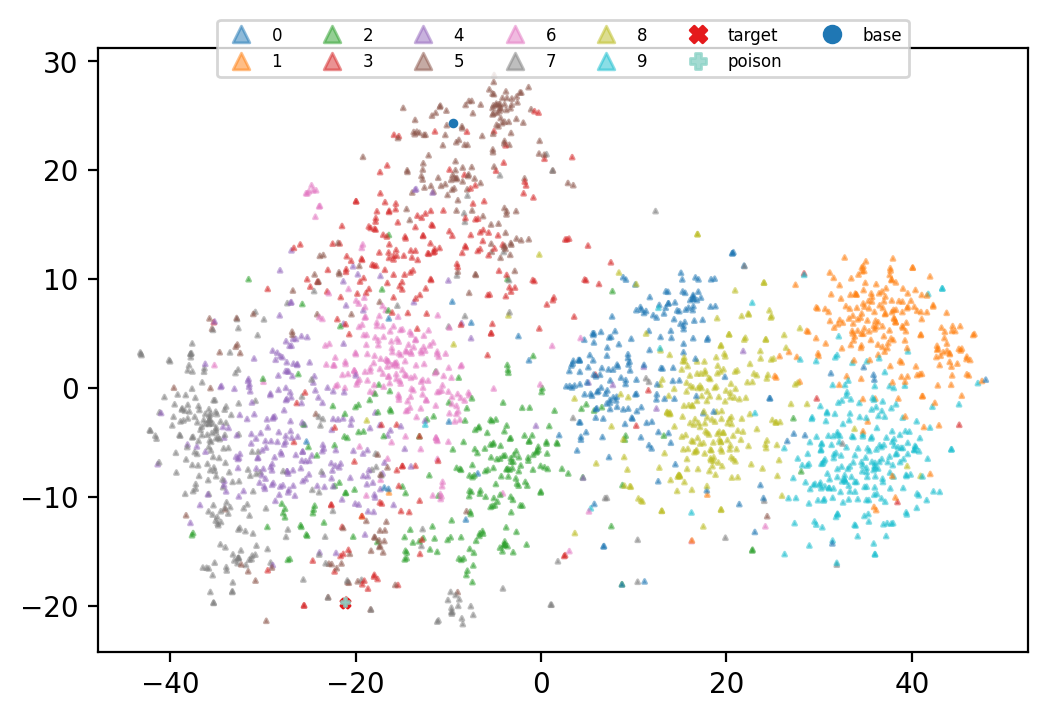

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.figure(dpi=200)
colors = cm.rainbow(np.linspace(0, 1, 10))
scatter = plt.scatter(*rep_2d[:-3].T, c=lb[:-3], cmap='tab10', marker='^', alpha=0.5, s=2)
# sns.scatterplot(*rep_2d.T, hue=lb, s=lb2)
plt.legend(*scatter.legend_elements())
lb2 = lb * 0.5
lb2[-3] = lb2[-3]+ 5
scatter1 = plt.scatter(*rep_2d[-3:-2].T, c=lb[-3:-2], cmap='Set1', marker='X', alpha=1, s=lb2[-3:-2]+1)
scatter2 = plt.scatter(*rep_2d[-2:-1].T, c=lb[-2:-1], cmap='Set3', marker='P', alpha=0.8, s=lb2[-2:-1]+1)
scatter3 = plt.scatter(*rep_2d[-1:].T, c=lb[-1:], cmap='tab10', marker='o', alpha=1, s=lb2[-1:])

a = scatter.legend_elements()[0]

b = scatter.legend_elements()[1]

a.extend(scatter1.legend_elements()[0])
a.extend(scatter2.legend_elements()[0])
a.extend(scatter3.legend_elements()[0])

b.extend(["target"])
b.extend(["poison"])
b.extend(['base'])

plt.legend(a,b, loc=9, ncol=7, fontsize=6, bbox_to_anchor=(0.5, 1.06),)
plt.show()